In [6]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.stats import multivariate_normal

with open("../fits/gmm_mp2.pkl", "rb") as f:
    gmm_ref = pickle.load(f)

n_components = gmm_ref.K
fixed_means = gmm_ref.mean.copy()
fixed_covariances = np.array([np.diag(np.diag(cov)) for cov in gmm_ref.covar])  # zero off-diagonals

gse_indices = [1, 2]      # example: replace with your GS/E indices
stationary_idx = 0        # example: replace with stationary halo index
prograde_idx = 3          # example: replace with prograde halo index
thick_disc_idx = 4        # example: replace with thick disc index

for i in range(n_components):
    if i not in gse_indices:
        fixed_means[i, 0] = 0  # v_R
    fixed_means[i, 2] = 0      # v_Z

with fits.open('../data/df_v_final.fits') as hdul:
    data = hdul[1].data
    df_v = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                         for col in hdul[1].columns})

df_v = df_v[np.abs(df_v['Z']) < 2.5]
df_v = df_v.dropna(subset=["v_R", "v_phi", "v_Z"])

bins = [(-3, -2), (-2, -1.6), (-1.6, -1.3), (-1.3, -1.0)]
bin_labels = ['VMP', 'IMP', 'MP1', 'MP2']
bin_centers = [np.mean(b) for b in bins]

fractions = {'stationary_halo': [], 'prograde_halo': [], 'GSE': [], 'thick_disc': []}

for (min_mh, max_mh), label in zip(bins, bin_labels):
    df_bin = df_v[(df_v['mh_xgboost'] >= min_mh) & (df_v['mh_xgboost'] < max_mh)]
    X_bin = df_bin[['v_R', 'v_phi', 'v_Z']].values

    # Compute likelihoods manually
    likelihoods = np.zeros((len(X_bin), n_components))
    for i in range(n_components):
        mvn = multivariate_normal(mean=fixed_means[i], cov=fixed_covariances[i])
        likelihoods[:, i] = mvn.pdf(X_bin)

    # Compute weights from responsibilities
    responsibilities = likelihoods / (likelihoods.sum(axis=1, keepdims=True))
    weights = responsibilities.sum(axis=0) / responsibilities.sum()

    # Map components
    fractions['stationary_halo'].append(weights[stationary_idx])
    fractions['prograde_halo'].append(weights[prograde_idx])
    gse_sum = np.sum([weights[i] for i in gse_indices])
    fractions['GSE'].append(gse_sum)
    fractions['thick_disc'].append(weights[thick_disc_idx])

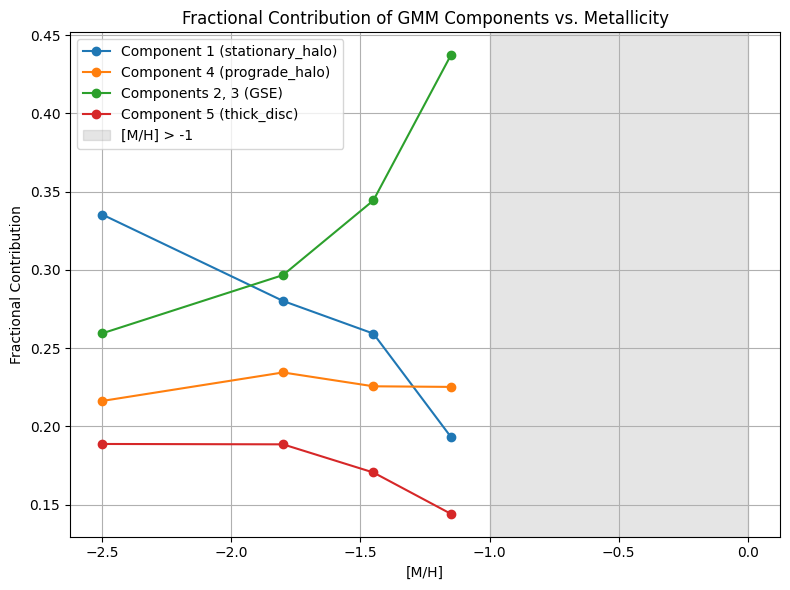

In [7]:
plt.figure(figsize=(8, 6))

# Assign component index labels (for clarity)
component_labels = {
    stationary_idx: 'Component {}'.format(stationary_idx + 1),
    prograde_idx: 'Component {}'.format(prograde_idx + 1),
    thick_disc_idx: 'Component {}'.format(thick_disc_idx + 1)
}

for i in gse_indices:
    component_labels[i] = 'Component {}'.format(i + 1)

# Plot each component’s fraction with its index label
for comp, frac_list in fractions.items():
    if comp == 'GSE':
        label = 'Components ' + ', '.join(str(i + 1) for i in gse_indices) + ' (GSE)'
    else:
        idx = {'stationary_halo': stationary_idx,
               'prograde_halo': prograde_idx,
               'thick_disc': thick_disc_idx}[comp]
        label = f'Component {idx + 1} ({comp})'

    plt.plot(bin_centers, frac_list, label=label, marker='o')

plt.axvspan(-1.0, 0, color='gray', alpha=0.2, label='[M/H] > -1')
plt.xlabel('[M/H]')
plt.ylabel('Fractional Contribution')
plt.title('Fractional Contribution of GMM Components vs. Metallicity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../figures/gmm_fraction_vs_metallicity.png', dpi=300)
plt.show()
